## Logistic Regression versus Bayesian Classifier


## Discriminative vs Generative Models

We are going to compare between probabilistic discriminative model (Logistic Regression) and probabilistic generative model (Bayesian Classifier). We use three model variants of Bayesian Classifier, namely:
- Naive Bayes : assumes conditional independence of features given the class label, i.e., no correlation between features. Each class has its own diagonal covariance matrix (variance per feature, no covariances)

- Bayesian Classifier Full Covariance (Not Shared) : assumes that the features are correlated, and each class has its own full covariance matrix

- Bayesian Classifier with Shared Covariance : assumes that the features are correlated, but all classes share a common full covariance matrix.

We use the `breast_cancer` dataset for this part. I prepared the data by splitting it into training and test dataset with `train_size` equal to 0.8. 

### I. Comparison between Models in Terms of Train and Test Performance

After preparing the data, I use `BayesianClassifier` for Bayes classifiers and `LogisticRegression` from `sklearn.linear_model` to fit the model and predict the target $y$. Then plot the `zero_one_loss` and `log_loss` of each corresponding training and test dataset.

In [14]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

breast_cancer = load_breast_cancer()
breast_cancer.data.shape, breast_cancer.target.shape

((569, 30), (569,))

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
from scipy.stats import multivariate_normal
import numpy as np

class BayesianClassifier:

    def __init__(self, shared_cov=True, cond_ind=True):
        self.shared_cov=shared_cov
        self.cond_ind=cond_ind

    def fit(self, x, y):
        self.classes_, class_counts = np.unique(y, return_counts=True)
        self.n_ , self.p_ = x.shape
        self.k_ = len(self.classes_)
        self.cond_means_ = np.zeros(shape=(self.k_, self.p_))
        self.cond_covs_ = np.zeros(shape=(self.k_, self.p_, self.p_))
        
        self.class_priors_ = class_counts/len(y)
        for c in range(self.k_):
            c_rows = y==c
            self.cond_means_[c, :] = x[c_rows].mean(axis=0)
            if self.cond_ind:
                np.fill_diagonal(self.cond_covs_[c, :, :], x[c_rows].var(axis=0))
            else:
                self.cond_covs_[c, :, :] = np.cov(x[c_rows].T, bias=True)

        if self.shared_cov:
            shared_cov = np.moveaxis(self.cond_covs_, 0, -1).dot(self.class_priors_)
            self.cond_covs_[:] = shared_cov

        return self

    def predict_proba(self, x):
        m, _ = x.shape
        cond_probs = np.zeros(shape=(m, self.k_))
        for c in range(self.k_):
            # find p(x | c_k)
            # singular covariance matrices could happen (e.g., through inaccurate estimation)
            cond_probs[:, c] = multivariate_normal.pdf(x, 
                                                       self.cond_means_[c],
                                                       self.cond_covs_[c],
                                                       allow_singular=True)
        # find marginal probabilities p(x) by summing all the conditionals weighted by the priors
        marginal_probs = cond_probs.dot(self.class_priors_)

        # find probability vector (p(c1 | x), ..., p(ck | x)) via p(ci | x)=p(x | ci) / p(x)
        # however, p(x) might have been rounded to 0
        # thus, compute via case distinction
        probs = np.divide((cond_probs*self.class_priors_).T,
                          marginal_probs,
                          where=marginal_probs>0, out=np.zeros(shape=(self.k_, m))).T
        return probs

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

    def decision_function(self, x):
        probs = self.predict_proba(x)
        if self.k_ == 2:
            return np.log(probs[:, 1]/probs[:, 0])
        else:
            res = np.zeros(len(x), self.k_)
            for c in range(self.k_):
                res[:, c]=np.log(probs[:, c]/(1-probs[:, c]))
            return res
        
    def generate(self, n, c, random_state=None):
        return multivariate_normal.rvs(self.cond_means_[c], self.cond_covs_[c], size=n, random_state=random_state)

#### Split the data into training and test datasets

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(breast_cancer.data, breast_cancer.target, train_size=0.8, random_state = 25, shuffle=True, stratify=breast_cancer.target)

#### Make a function to test the models performance

I use the `plot_model_performances` function to compare the models with `zero_one_loss` and `log_loss`. Zero-one loss measures the misclassification of the model, while log loss measures how confident and well-calibrated the classifier is. Log loss penalizes wrong predictions more when the model is confident but incorrect.

In the following code and plot I use the shortened names for each model: 
- Logistic Regression : LR
- Naive Bayes : NB
- Bayesian Classifier with Full Covariance (Not Shared) : BC
- Bayesian Classifier with Shared Covariance : BCs or BC (shared)

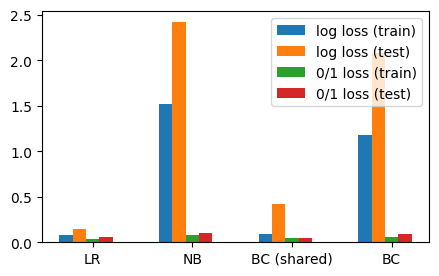

In [13]:
from sklearn.metrics import zero_one_loss, log_loss
import matplotlib.pyplot as plt

def plot_model_performances(models, model_names, x_train, y_train, x_test, y_test):
    train_01_losses = []
    train_log_losses = []
    test_01_losses = []
    test_log_losses = []

    for i, model in enumerate(models):
        train_01_losses.append(zero_one_loss(y_train, model.predict(x_train)))
        train_log_losses.append(log_loss(y_train, model.predict_proba(x_train)))
        test_01_losses.append(zero_one_loss(y_test, model.predict(x_test)))
        test_log_losses.append(log_loss(y_test, model.predict_proba(x_test)))

    group_spacing = 1.5
    xx = np.arange(len(models))*group_spacing
    bar_width = 1/(len(models)+1)
    group_width = len(models)*bar_width
    
    plt.bar(xx-group_width/2, train_log_losses, width=bar_width, label='log loss (train)')
    plt.bar(xx-group_width/2 + bar_width, test_log_losses, width=bar_width, label='log loss (test)')
    plt.bar(xx-group_width/2 + 2*bar_width, train_01_losses, width=bar_width, label='0/1 loss (train)')
    plt.bar(xx-group_width/2 +3*bar_width, test_01_losses, width=bar_width, label='0/1 loss (test)')
    plt.xticks(xx, model_names)

# Fit each model according to the assumptions
lr = LogisticRegression(max_iter=10000,fit_intercept=True).fit(x_train, y_train)
nb = BayesianClassifier(shared_cov=False, cond_ind=True).fit(x_train, y_train)
bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False).fit(x_train, y_train)
bc = BayesianClassifier(shared_cov=False, cond_ind=False).fit(x_train, y_train)

# Store the fitted models for plotting
models = [lr, nb, bc_shared, bc]
model_names = ['LR', 'NB', 'BC (shared)', 'BC']

plt.subplots(1, 1, figsize=(5, 3))
plot_model_performances(models, model_names, x_train, y_train, x_test, y_test)
plt.legend()
plt.show()


As we can see in the plot, the Logistic Regression performs best in terms of train and test performance. It looks like it has the lowest loss and error rate (zero-one loss rate) for all of the measurement. It's especially visible from the result of the log loss, that not only takes into account whether the classification is right or wrong, but also the confidence of the model when classifying input data.

### II. Implement Experiment to Test Performance Based on Training Sizes

In this part, we want to see the effect of training sizes to the performance of each models. I split the data into training and test dataset with `train_size` equal to 0.9. This is because the shape of the data is only 569 rows, and we want to test at maximum training size equal to 500. That means, if I take the training dataset only 80% of the data, then the training dataset will not be enough to be sampled. 

This is what the nested loops below does:
- randomly pick the indices of the training dataset to sample it according to the corresponding `train_size`
- fit the resampled training dataset into each model 
- store the fitted models
- do the steps above 10 times for each train size

After getting all the fitted models, I compute the mean errors for each train size for each model then plot them all model together, making one plot for each of the loss measures. 

In [ ]:
from sklearn.metrics import zero_one_loss, log_loss

# Split the data into training and test dataset
x_train, x_test, y_train, y_test = train_test_split(breast_cancer.data, breast_cancer.target, train_size=0.9, random_state = 25, shuffle=True)

# Initialization
train_sizes = range(5, 501, 5)
fitted_models_LR = [[] for _ in train_sizes]
fitted_models_NB = [[] for _ in train_sizes]
fitted_models_BC_shared = [[] for _ in train_sizes]
fitted_models_BC = [[] for _ in train_sizes]

for i,train_size in enumerate(train_sizes):
    for j in range(10):
        while True:
            idx = np.random.choice(len(x_train),train_size,replace=False)
            x_train_resampled = x_train[idx]
            y_train_resampled = y_train[idx]
            if len(np.unique(y_train_resampled)) == 1: # To make sure that the training target has more than one class
                continue
            else: break

        # Fit each model accordingly
        model_lr = LogisticRegression(max_iter=10000,fit_intercept=True).fit(x_train_resampled, y_train_resampled)
        model_nb = BayesianClassifier(shared_cov=False, cond_ind=True).fit(x_train_resampled, y_train_resampled)
        model_bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False).fit(x_train_resampled, y_train_resampled)
        model_bc = BayesianClassifier(shared_cov=False, cond_ind=False).fit(x_train_resampled, y_train_resampled)

        # Store the fitted models for each train size
        fitted_models_LR[i].append(model_lr)
        fitted_models_NB[i].append(model_nb)
        fitted_models_BC_shared[i].append(model_bc_shared)
        fitted_models_BC[i].append(model_bc)


In [17]:
# Create containers for mean errors by train size for Logistic Regression
LR_train_01 = []
LR_test_01 = []
LR_train_log = []
LR_test_log = []

# Loop over each training size (outer loop)
for models_at_size in fitted_models_LR:
    # temporary lists to store errors for 10 repetitions
    temp_train_01 = []
    temp_test_01 = []
    temp_train_log = []
    temp_test_log = []
    
    # Loop over each repetition for the given training size
    for model in models_at_size:
        temp_train_01.append(zero_one_loss(y_train, model.predict(x_train)))
        temp_test_01.append(zero_one_loss(y_test, model.predict(x_test)))
        temp_train_log.append(log_loss(y_train, model.predict_proba(x_train)))
        temp_test_log.append(log_loss(y_test, model.predict_proba(x_test)))
    
    # Compute the mean errors over the 10 repetitions
    LR_train_01.append(np.mean(temp_train_01))
    LR_test_01.append(np.mean(temp_test_01))
    LR_train_log.append(np.mean(temp_train_log))
    LR_test_log.append(np.mean(temp_test_log))

# Create containers for mean errors by train size for Naive Bayes
NB_train_01 = []
NB_test_01 = []
NB_train_log = []
NB_test_log = []

# Loop over each training size (outer loop)
for models_at_size in fitted_models_NB:
    # temporary lists to store errors for 10 repetitions
    temp_train_01 = []
    temp_test_01 = []
    temp_train_log = []
    temp_test_log = []
    
    # Loop over each repetition for the given training size
    for model in models_at_size:
        temp_train_01.append(zero_one_loss(y_train, model.predict(x_train)))
        temp_test_01.append(zero_one_loss(y_test, model.predict(x_test)))
        temp_train_log.append(log_loss(y_train, model.predict_proba(x_train)))
        temp_test_log.append(log_loss(y_test, model.predict_proba(x_test)))
    
    # Compute the mean errors over the 10 repetitions
    NB_train_01.append(np.mean(temp_train_01))
    NB_test_01.append(np.mean(temp_test_01))
    NB_train_log.append(np.mean(temp_train_log))
    NB_test_log.append(np.mean(temp_test_log))

# Do the same for Bayesian Classifier with Shared Covariance
BCs_train_01 = []
BCs_test_01 = []
BCs_train_log = []
BCs_test_log = []

for models_at_size in fitted_models_BC_shared:
    temp_train_01 = []
    temp_test_01 = []
    temp_train_log = []
    temp_test_log = []
    
    for model in models_at_size:
        temp_train_01.append(zero_one_loss(y_train, model.predict(x_train)))
        temp_test_01.append(zero_one_loss(y_test, model.predict(x_test)))
        temp_train_log.append(log_loss(y_train, model.predict_proba(x_train)))
        temp_test_log.append(log_loss(y_test, model.predict_proba(x_test)))
    
    BCs_train_01.append(np.mean(temp_train_01))
    BCs_test_01.append(np.mean(temp_test_01))
    BCs_train_log.append(np.mean(temp_train_log))
    BCs_test_log.append(np.mean(temp_test_log))
    
# Bayesian Classifier without Shared Covariance:
BC_train_01 = []
BC_test_01 = []
BC_train_log = []
BC_test_log = []

for models_at_size in fitted_models_BC:
    temp_train_01 = []
    temp_test_01 = []
    temp_train_log = []
    temp_test_log = []
    
    for model in models_at_size:
        temp_train_01.append(zero_one_loss(y_train, model.predict(x_train)))
        temp_test_01.append(zero_one_loss(y_test, model.predict(x_test)))
        temp_train_log.append(log_loss(y_train, model.predict_proba(x_train)))
        temp_test_log.append(log_loss(y_test, model.predict_proba(x_test)))
    
    BC_train_01.append(np.mean(temp_train_01))
    BC_test_01.append(np.mean(temp_test_01))
    BC_train_log.append(np.mean(temp_train_log))
    BC_test_log.append(np.mean(temp_test_log))


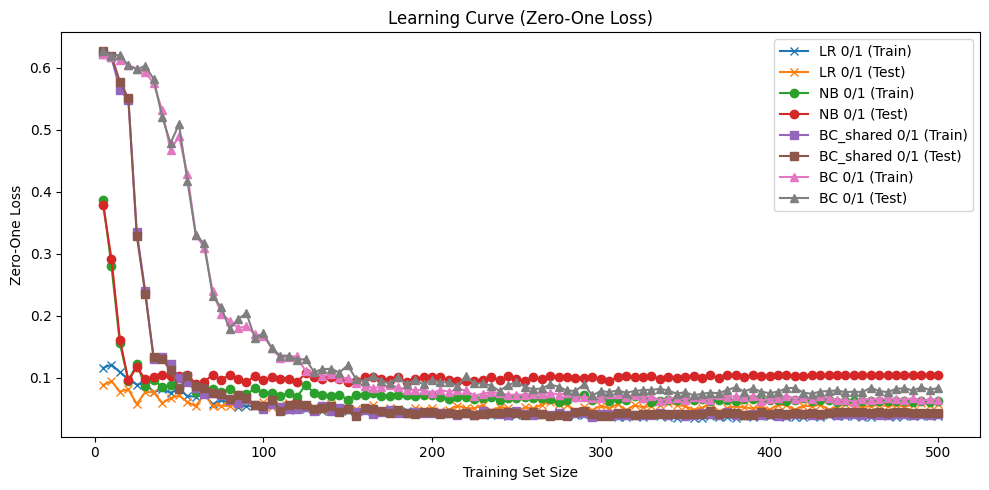

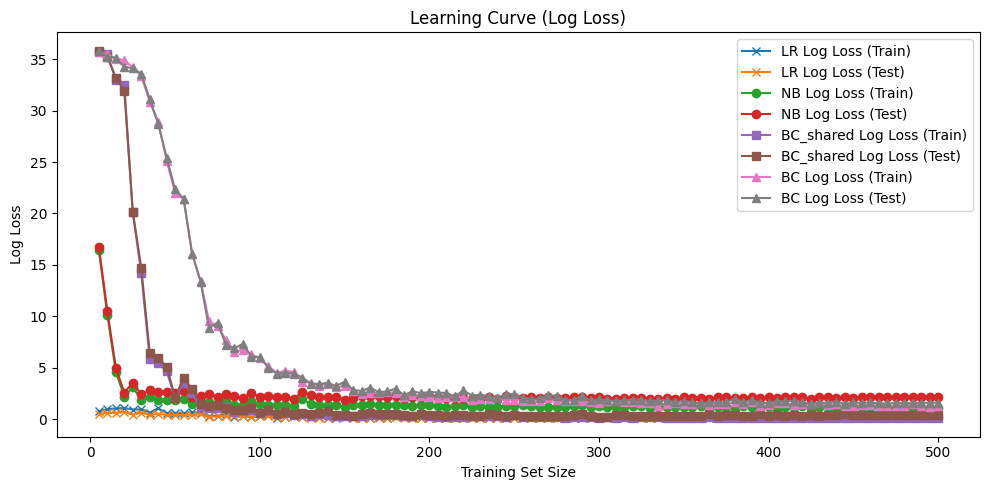

In [18]:
import matplotlib.pyplot as plt

# Create a list of training sizes 
train_sizes_list = list(range(5, 501, 5))

# --- Zero-One Loss Plot ---
plt.figure(figsize=(10, 5))
plt.plot(train_sizes_list, LR_train_01, label='LR 0/1 (Train)', marker='x')
plt.plot(train_sizes_list, LR_test_01, label='LR 0/1 (Test)', marker='x')
plt.plot(train_sizes_list, NB_train_01, label='NB 0/1 (Train)', marker='o')
plt.plot(train_sizes_list, NB_test_01, label='NB 0/1 (Test)', marker='o')
plt.plot(train_sizes_list, BCs_train_01, label='BC_shared 0/1 (Train)', marker='s')
plt.plot(train_sizes_list, BCs_test_01, label='BC_shared 0/1 (Test)', marker='s')
plt.plot(train_sizes_list, BC_train_01, label='BC 0/1 (Train)', marker='^')
plt.plot(train_sizes_list, BC_test_01, label='BC 0/1 (Test)', marker='^')
plt.xlabel("Training Set Size")
plt.ylabel("Zero-One Loss")
plt.title("Learning Curve (Zero-One Loss)")
plt.legend()
plt.tight_layout()
plt.show()

# --- Log Loss Plot ---
plt.figure(figsize=(10, 5))
plt.plot(train_sizes_list, LR_train_log, label='LR Log Loss (Train)', marker='x')
plt.plot(train_sizes_list, LR_test_log, label='LR Log Loss (Test)', marker='x')
plt.plot(train_sizes_list, NB_train_log, label='NB Log Loss (Train)', marker='o')
plt.plot(train_sizes_list, NB_test_log, label='NB Log Loss (Test)', marker='o')
plt.plot(train_sizes_list, BCs_train_log, label='BC_shared Log Loss (Train)', marker='s')
plt.plot(train_sizes_list, BCs_test_log, label='BC_shared Log Loss (Test)', marker='s')
plt.plot(train_sizes_list, BC_train_log, label='BC Log Loss (Train)', marker='^')
plt.plot(train_sizes_list, BC_test_log, label='BC Log Loss (Test)', marker='^')
plt.xlabel("Training Set Size")
plt.ylabel("Log Loss")
plt.title("Learning Curve (Log Loss)")
plt.legend()
plt.tight_layout()
plt.show()


### Analytical questions and answers
**a. What happens to each classifier’s train and test performance when the number of training data points is increased?**

As the training size increases, all classifiers show better performance, the losses (log loss) and error rates (zero-one loss) go down and start to stabilize. In general:
- The models become more consistent and show less fluctuation.
- The test performance improves and gets closer to the training performance.

Below is the analysis for each model:

- Logistic Regression : we can see that from beginning the loss and the error rate are quite low already compared to other models. As the train size increases, the performance remains stable. Overall, this model performance stabilize the fastest among all models.

- Naive Bayes : for small train sizes, it is the second best in terms of performance. In the bigger train sizes, this model seems to have the worst performance among all models for both metrics. Particularly for the error rates, as the train size increases, there is an increasing gap between train and test performance, which could suggests underfitting.

- Bayesian Classifier with Shared Covariance : as the train size increases, it starts to perform better and better. Both in log loss and zero-one loss, it has the best performance at the larger train sizes, particularly starting from around size 300 and above.

- Bayesian Classifier with Full Covariance (Not Shared) : this variant of Bayesian classifier seems to "converge" the slowest. As the train size grows, the performance does improve but it only seems to start stabilizing around train size 150, while other models losses and error rates already dropping significantly below train size 50. 

So overall, increasing the training data helps all models, but the amount of data needed varies depending on the model's complexity.

**b. Which classifier is best suited when the training set is small, and which is best suited when the training set is big?**

When the training size is small, Logistic Regression performs the best — both the log loss and zero-one loss are already low early on, and it stabilizes quickly.

When the training size is large, Bayesian Classifier with Shared Covariance ends up being the best. Around size 300 and above, its performance becomes noticeably better than the other models for both loss metrics.

**c. Justify your observations by providing some speculations and possible reasons.**

These patterns likely come down to the complexity of each model and the assumptions they make:

- Logistic Regression is quite simple with fewer parametesrs and doesn’t make many assumptions, so it doesn’t overfit easily and works well even when data is limited. Since it already assume linearity and has regularized structure, the overall variance of this model is smaller. That’s probably why it performs the best at small train sizes.

- Naive Bayes is also simple and works well at the start, but it has strong independence assumptions that might be simplifying model learning. As more data reveals correlations between features, this model disregard them and underfits the data. That could be why it ends up performing the worst overall at larger sizes.

- Bayesian Classifier with Shared Covariance balances flexibility and simplicity. It simplifies model learning like Naive Bayes but is more flexible. It has fewer parameters to estimate than the full covariance version, so it benefits more quickly from additional data and becomes the best performer at large sizes.

- Bayesian Classifier with Full Covariance is the most flexible but also the most complex, due to its assumptions, it has to estimate a full covariance matrix for each class. Thus it needs much more data to properly estimate all its parameters. That’s probably why it takes much longer to “converge” compared to the others.

These differences reflect the trade-off between bias and variance, and how the number of parameters and model assumptions impact learning from limited data. Simpler models perform better with limited data, while more complex models need more data to avoid overfitting or high variance.

